# Ungraded Lab: Preprocessing Images to Train a Neural Network

Real world image datasets might not come as neatly packaged as the ones you've been using so far. Oftentimes, you will need to prepare them first before they can be fed to your model efficiently. You will see how to do that in this lab.

In particular, you will:
* build and train a model on the [Horses or Humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset. This contains over a thousand images of horses and humans with varying poses and filesizes.
*  preprocess these different images using the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) utility
* use the [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize the images
* chain different methods of the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to configure it for performance

Finally, you will upload images from the internet to see how your model distinguishes between horses and humans. Let's begin!


## Import the Libraries

Start with importing all the libraries you will need.

In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

## Preview the Dataset

The dataset is already downloaded in your lab environment. It's on the base directory `horse-or-human`, which in turn contains `horses` and `humans` subdirectories. By arranging the data this way, you do not need to explicitly label the images as horses or humans. The utility you will use later automatically labels images according to this directory structure.

In [3]:
TRAIN_DIR = 'Images\Training'

# You should see a `horse-or-human` folder here
print(f"files in current directory: {os.listdir()}")

# Check the subdirectories
print(f"\nsubdirectories within '{TRAIN_DIR}' dir: {os.listdir(TRAIN_DIR)}")

files in current directory: ['00 Introduction A conversation with Andrew Ng.mp4', '01 A primer in machine learning.mp4', '02 The ‘Hello World’ of neural networks.mp4', '03 Working through ‘Hello World’ in TensorFlow and Python.mp4', '04 A Conversation with Andrew Ng.mp4', '05 An Introduction to computer vision.mp4', '06 Writing code to load training data.mp4', '07 Coding a Computer Vision Neural Network.mp4', '08 Walk through a Notebook for computer vision.mp4', '09 Using Callbacks to control training.mp4', '10 Walk through a notebook with Callbacks.mp4', '11 A conversation with Andrew Ng.mp4', '12 What are convolutions and pooling.mp4', '13 Implementing convolutional layers.mp4', '14 Implementing pooling layers.mp4', '15 Improving the Fashion classifier with convolutions.mp4', '16 Walking through convolutions.mp4', '17 A conversation with Andrew Ng.mp4', '18 Understanding the tf.data API.mp4', '19 Defining a ConvNet to use complex images.mp4', '20 Training the ConvNet.mp4', '21 Walkin

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ayush\AppData\Local\Temp\ipykernel_22304\3723150152.py:1: SyntaxWarning: invalid escape sequence '\T'
  TRAIN_DIR = 'Images\Training'


Now see what the filenames look like in the `horses` and `humans` training directories:

In [4]:
# Directory with the training horse pictures
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')

# Directory with the training human pictures
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Check the filenames
train_horse_names = os.listdir(train_horse_dir)
print(f"5 files in horses subdir: {train_horse_names[:5]}")
train_human_names = os.listdir(train_human_dir)
print(f"5 files in humans subdir:{train_human_names[:5]}")

5 files in horses subdir: ['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png']
5 files in humans subdir:['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png']


You can also find out the total number of images in each directory:

In [5]:
print(f"total training horse images: {len(os.listdir(train_horse_dir))}")
print(f"total training human images: {len(os.listdir(train_human_dir))}")

total training horse images: 500
total training human images: 527


Take a look at a few pictures to get a better sense of what they look like. Display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

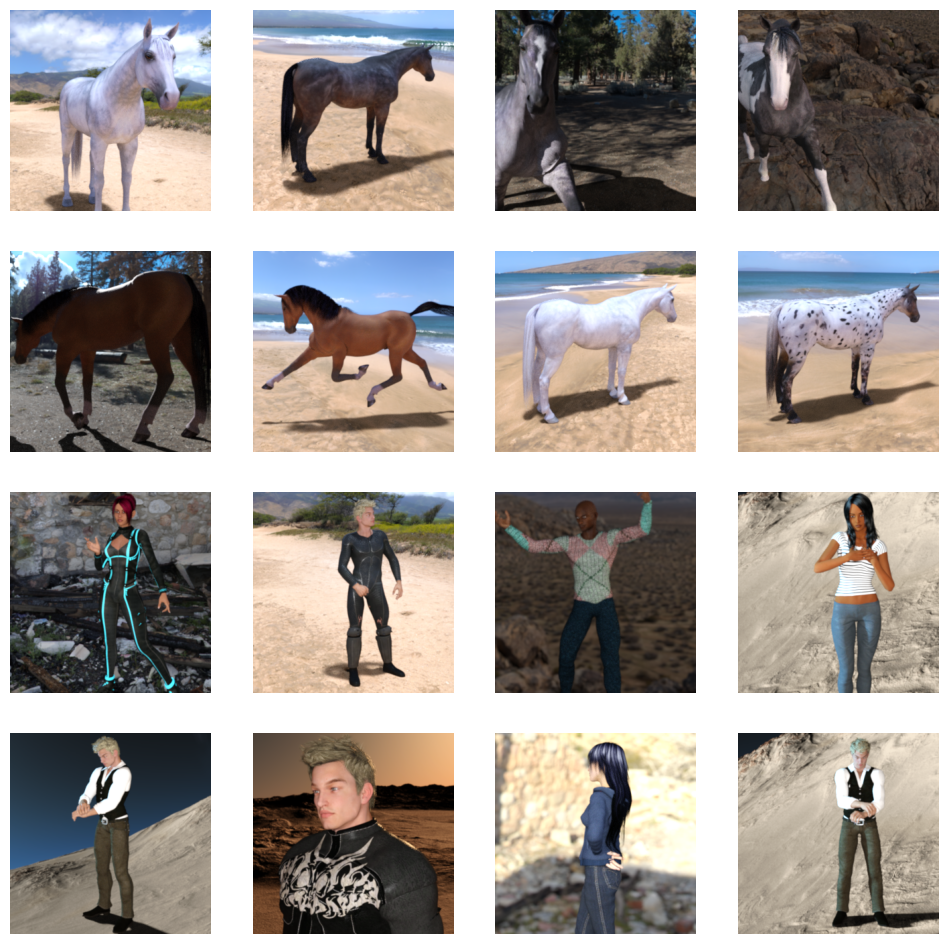

In [6]:
# Parameters for your graph; you will output images in a 4x4 configuration
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in random.sample(train_horse_names, k=8)]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in random.sample(train_human_names, k=8)]

for i, img_path in enumerate(next_horse_pix + next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

Now you will define the model architecture. You will add convolutional layers as in last week's labs, and flatten the final result to feed into the densely connected layers. Note that because this is a two-class classification problem (i.e. a *binary classification problem*) you will end your network with a [sigmoid activation](https://wikipedia.org/wiki/Sigmoid_function). This makes the output value of your network to be a number between 0 and 1. The closer it is to 0, the more likely that the image is a horse. The closer it is to 1, the more likely the image is a human.

In [7]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.Input(shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0 to 1 where 0 is for 'horses' and 1 for 'humans'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can review the network architecture and the output shapes with `model.summary()`.

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

The "output shape" column shows how the size of your feature map evolves in each successive layer. As you saw in an earlier lesson, the convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.

Next, you'll configure the specifications for model training. You will train the model with the [`binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss because it's a binary classification problem, and the final activation is a sigmoid. (_For a refresher on loss metrics, see this [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture)._) You will use the `RMSProp` optimizer with a learning rate of `0.001`. During training, you will want to monitor classification accuracy.

_**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)_

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Next is to prepare the dataset so it can be consumed by the model efficiently while training. To do that, you will use the [`image_from_dataset_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) utility to read pictures in the source folders, convert them to tensors, and combine them with their labels to form a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). This uses the [tf.data API](https://www.tensorflow.org/guide/data) which is optimized for parallel processing such as feeding data to GPUs and TPUs. It makes the training much faster than when using regular Numpy arrays.

To use this utility, you only need to set the base directory. You can set additional arguments if you want to modify the defaults. In this case, you will set the resizing dimensions of the images, the batch size, and the type of labelling to apply. By default, the labels are assigned alphabetically. In this case, the said utility will assign the label `0` to the images in the `horses` directory and the label `1` to those in `humans`.

In [10]:
# Instantiate the dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(300, 300),
    batch_size=32,
    label_mode='binary'
    )

# Check the type
dataset_type = type(train_dataset)
print(f'train_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}')

Found 1027 files belonging to 2 classes.
train_dataset inherits from tf.data.Dataset: True


You can examine one example to inspect how the data is structured. The cell below gets one batch of data using the [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method and extracts the data. This should be a tuple of 2 elements which corresponds to an `(image, label)` pair. You can examine it further and confirm by checking the shape of the elements. The first should have `(300,300,3)` corresponding to the images and the other should have `(1)` for the single number labels. Both will have an additional `128` in front for the batch size set earlier.

In [11]:
# Get one batch from the dataset
sample_batch = list(train_dataset.take(1))[0]

# Check that the output is a pair
print(f'sample batch data type: {type(sample_batch)}')
print(f'number of elements: {len(sample_batch)}')

# Extract image and label
image_batch = sample_batch[0]
label_batch = sample_batch[1]

# Check the shapes
print(f'image batch shape: {image_batch.shape}')
print(f'label batch shape: {label_batch.shape}')

sample batch data type: <class 'tuple'>
number of elements: 2
image batch shape: (32, 300, 300, 3)
label batch shape: (32, 1)


You can also preview the image array so you can compare the pixel values later in the next step of the preprocessing.

In [16]:
print(image_batch[0].numpy())

[[[158. 175. 185.]
  [156. 173. 184.]
  [154. 172. 183.]
  ...
  [184. 188. 191.]
  [183. 187. 190.]
  [180. 185. 189.]]

 [[152. 170. 182.]
  [152. 170. 181.]
  [151. 169. 181.]
  ...
  [186. 190. 192.]
  [185. 189. 191.]
  [181. 186. 189.]]

 [[148. 167. 179.]
  [148. 166. 179.]
  [148. 166. 179.]
  ...
  [187. 191. 192.]
  [185. 189. 191.]
  [181. 186. 189.]]

 ...

 [[ 66.  55.  46.]
  [ 67.  56.  48.]
  [ 68.  57.  49.]
  ...
  [ 49.  42.  38.]
  [ 42.  36.  33.]
  [ 33.  28.  26.]]

 [[ 67.  55.  47.]
  [ 66.  55.  47.]
  [ 66.  55.  47.]
  ...
  [ 55.  47.  41.]
  [ 43.  37.  33.]
  [ 34.  29.  26.]]

 [[ 66.  55.  47.]
  [ 65.  54.  47.]
  [ 63.  53.  46.]
  ...
  [ 58.  50.  43.]
  [ 44.  38.  33.]
  [ 35.  30.  26.]]]


Getting the minimum and maximum pixel values of the random image can give an estimate of the range present in the dataset. You should expect 0 to 255 but the random image you got may not have these extremes.

In [13]:
# Check the range of values
print(f'max value: {np.max(image_batch[0].numpy())}')
print(f'min value: {np.min(image_batch[0].numpy())}')

max value: 221.0
min value: 5.0


As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range.

In Tensorflow, you can use preprocessing layers to do this for you. In this case, you will use the [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer. Here, you will pass in the scale you want to apply to the original pixels.

In [14]:
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)

You can feed the image array you used earlier to verify that it works.

In [15]:
image_scaled = rescale_layer(image_batch[0]).numpy()


print(image_scaled)

[[[0.61960787 0.6862745  0.7254902 ]
  [0.6117647  0.6784314  0.72156864]
  [0.6039216  0.6745098  0.7176471 ]
  ...
  [0.72156864 0.7372549  0.7490196 ]
  [0.7176471  0.73333335 0.74509805]
  [0.7058824  0.7254902  0.7411765 ]]

 [[0.59607846 0.6666667  0.7137255 ]
  [0.59607846 0.6666667  0.70980394]
  [0.5921569  0.6627451  0.70980394]
  ...
  [0.7294118  0.74509805 0.75294125]
  [0.7254902  0.7411765  0.7490196 ]
  [0.70980394 0.7294118  0.7411765 ]]

 [[0.5803922  0.654902   0.7019608 ]
  [0.5803922  0.6509804  0.7019608 ]
  [0.5803922  0.6509804  0.7019608 ]
  ...
  [0.73333335 0.7490196  0.75294125]
  [0.7254902  0.7411765  0.7490196 ]
  [0.70980394 0.7294118  0.7411765 ]]

 ...

 [[0.25882354 0.21568629 0.18039216]
  [0.2627451  0.21960786 0.18823531]
  [0.26666668 0.22352943 0.19215688]
  ...
  [0.19215688 0.16470589 0.14901961]
  [0.16470589 0.14117648 0.12941177]
  [0.12941177 0.10980393 0.10196079]]

 [[0.2627451  0.21568629 0.18431373]
  [0.25882354 0.21568629 0.18431373]


In [17]:
print(f'max value: {np.max(image_scaled)}')
print(f'min value: {np.min(image_scaled)}')

max value: 0.8666667342185974
min value: 0.019607843831181526


There are a couple of ways to apply this transformation to the entire dataset and you will try one of them here (you will see the other approach in another course). You will develop a function that does the rescaling and pass it to the [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method.

You know that the dataset comes in `(image, label)` pairs so your function needs to accept those parameters and also output the same pair but with the image rescaled. You will do that below using a [`lambda function`](https://www.learnpython.org/en/Lambda_functions). There's an equivalent approach commented out if you want to declare a separate function.

In [19]:
# Rescale the image using a lambda function
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))


# # Same result as above but without using a lambda function
# # define a function to rescale the image
# def rescale_image(image, label):
#     return rescale_layer(image), label

# dataset_scaled = dataset.map(rescale_image)

As a sanity check, you can do a similar process from earlier and check the range of pixel values.

In [21]:
# Get one batch of data
sample_batch =  list(train_dataset_scaled.take(1))[0]

# Get the image
image_scaled = sample_batch[0][1].numpy()

# Check the range of values for this image
print(f'max value: {np.max(image_scaled)}')
print(f'min value: {np.min(image_scaled)}')

max value: 0.9529412388801575
min value: 0.003921568859368563


Lastly, you will chain in a few more methods to configure the dataset:
* [cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stores elements in memory as you use them so it will be faster to retrieve if you need them again
* [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), as the name suggests, shuffles the dataset randomly. A `buffer_size` of 1000 means it will first select a sample from the first 1,000 elements, then keep filling this buffer until all elements have been selected.
* [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) gets elements while the model is training so it's faster to feed in new data when the current training step is finished. A `buffer_size` set to `tf.data.AUTOTUNE` dynamically sets the number of elements to prefetch during runtime.

`cache()` and `prefetch()` are particularly useful in speeding up the training. Try removing these later and you'll see that the training time per epoch will take about 3 to 4 times longer.

In [22]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

### Training

You can start training for 15 epochs. Do note the values per epoch.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures how far the current model prediction is from the known labels. `accuracy`, on the other hand, is the portion of correct guesses.

In [23]:
history = model.fit(
    train_dataset_final,
    epochs=15,
    verbose=2
    )

Epoch 1/15
33/33 - 12s - 357ms/step - accuracy: 0.5910 - loss: 0.6801
Epoch 2/15
33/33 - 10s - 292ms/step - accuracy: 0.8296 - loss: 0.4548
Epoch 3/15
33/33 - 10s - 298ms/step - accuracy: 0.9484 - loss: 0.1684
Epoch 4/15
33/33 - 9s - 281ms/step - accuracy: 0.9552 - loss: 0.1175
Epoch 5/15
33/33 - 9s - 278ms/step - accuracy: 0.9786 - loss: 0.0459
Epoch 6/15
33/33 - 9s - 281ms/step - accuracy: 0.9679 - loss: 0.1498
Epoch 7/15
33/33 - 9s - 281ms/step - accuracy: 0.9990 - loss: 0.0072
Epoch 8/15
33/33 - 9s - 280ms/step - accuracy: 0.9601 - loss: 0.1918
Epoch 9/15
33/33 - 9s - 286ms/step - accuracy: 0.9786 - loss: 0.0927
Epoch 10/15
33/33 - 10s - 290ms/step - accuracy: 0.9942 - loss: 0.0167
Epoch 11/15
33/33 - 9s - 277ms/step - accuracy: 0.9727 - loss: 0.3715
Epoch 12/15
33/33 - 9s - 277ms/step - accuracy: 0.9864 - loss: 0.0308
Epoch 13/15
33/33 - 10s - 295ms/step - accuracy: 1.0000 - loss: 7.0776e-04
Epoch 14/15
33/33 - 10s - 296ms/step - accuracy: 1.0000 - loss: 1.7179e-04
Epoch 15/15
33/

Now you can plot the evolution of the accuracy over every epoch of training:

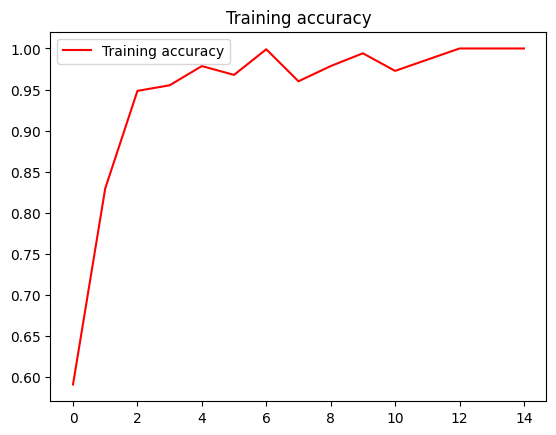

In [24]:
# Plot the training accuracy for each epoch

acc = history.history['accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.show()

As expected, accuracy improves over time! Nice!

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [25]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(300, 300))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a human")
        else:
            print(filename + " is a horse")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

# Run the interactive widget
# Note: it may take a bit after you select the image to upload and process before you see the output.
uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

C:\Users\ayush\AppData\Local\Temp\ipykernel_22304\1170845695.py:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
C:\Users\ayush\AppData\Local\Temp\ipykernel_22304\1170845695.py:44: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


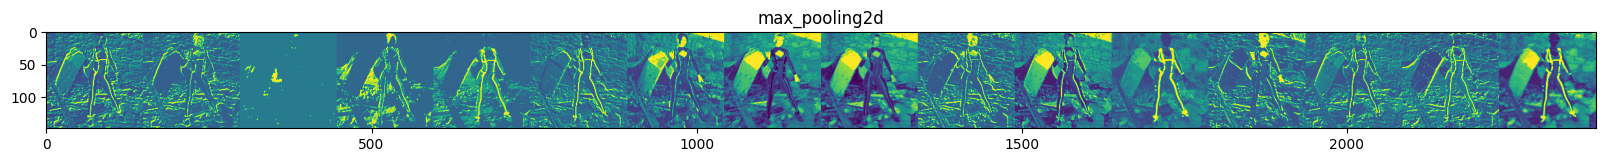

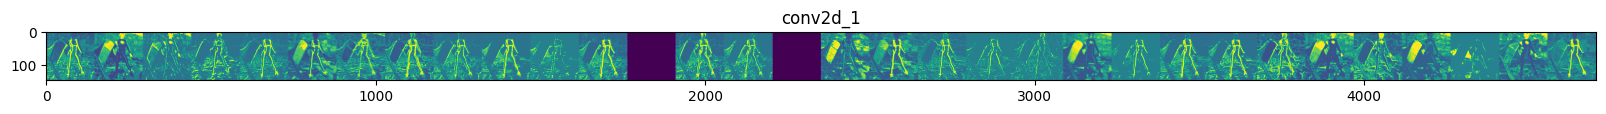

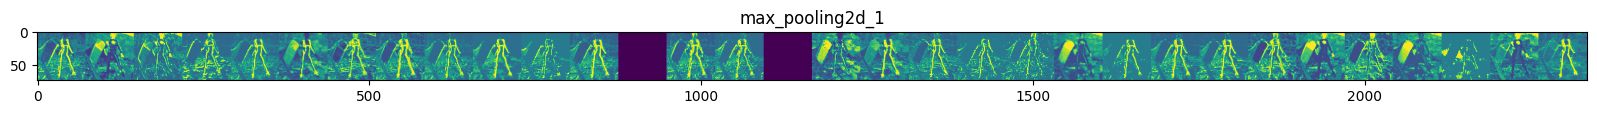

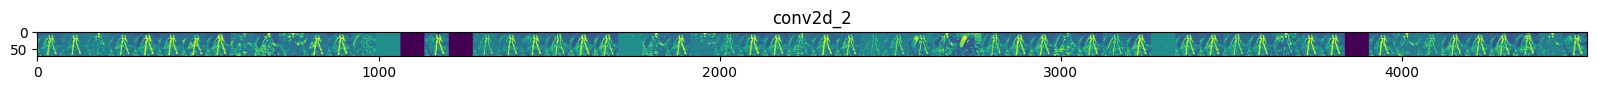

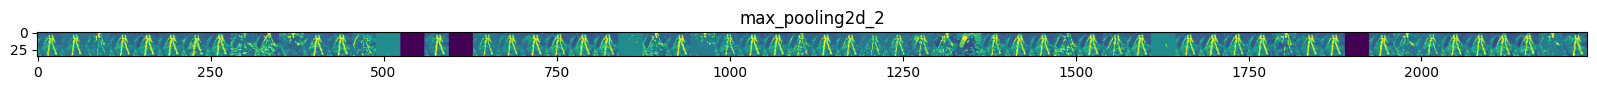

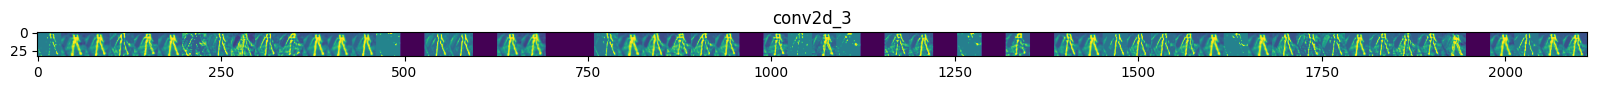

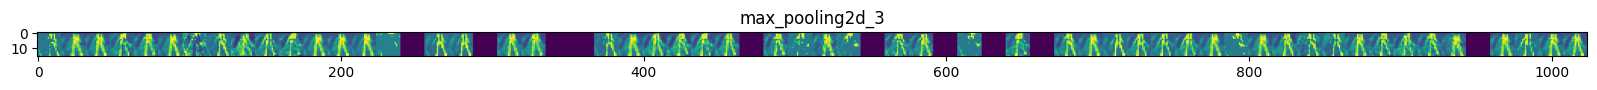

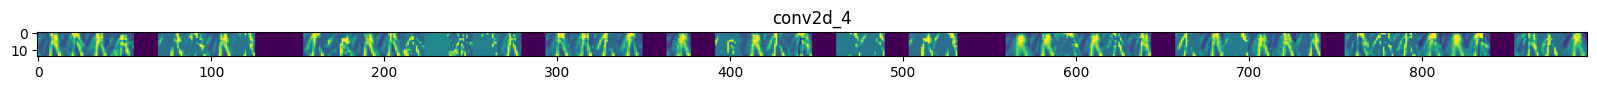

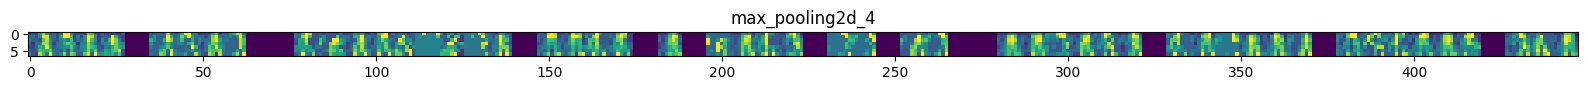

In [26]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = tf.keras.utils.load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = tf.keras.utils.img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x = rescale_layer(x)

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x, verbose=False)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a neural network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

## Wrap Up

This concludes this first lab on image data preprocessing, and you will build upon the results here in the next lessons. Before doing so, run the cell below to free up resources for the next lab. You might see a pop-up about restarting the kernel afterwards. You can safely ignore it and just press `Ok`. You can then close this lab, then go back to the classroom for the next lecture. See you there!

In [27]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}

: 